In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.style.use("seaborn-whitegrid")

# Define constants

In [3]:
LATS_CESM_STRING = ['4287', '4382', '4476', '4570', '4664', '4759', '4853', '4947']
LONS_CESM_STRING = ['0', '125', '250', '375', '500', '625', '750', '875', '1000', '1125', '1250', '1375', '1500']

MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"]

# Define helpful functions

In [4]:
def calc_pot_temp(T, p):
    p_0 = 1000.0
    c_p = 1005.0
    R = 287.0

    pot_temp = (T+273.15)*(p_0/p)**(R/c_p)
    return pot_temp

# Read merged meterological & foehn data

In [7]:
df_ERA = pd.read_csv("/net/litho/atmosdyn2/chmony/data/FoehnAndMeteorologicalData/ERAI_and_Foehn_data.csv.gz", parse_dates=["date"])
#df_ERA["date"] = pd.to_datetime(df_ERA["date"], format="%Y-%m-%dT%H:%M:00.000Z")
df_ERA.dropna(inplace=True)

date              datetime64[ns]
Foehn                    float64
Q_4287_0_500             float64
Q_4287_0_700             float64
Q_4287_0_850             float64
                       ...      
Z_4947_750_700           float64
Z_4947_750_850           float64
Z_4947_875_500           float64
Z_4947_875_700           float64
Z_4947_875_850           float64
Length: 1770, dtype: object

# Use only features which are also in CESM and which are not in the Alps

In [8]:
# Only allow features which also exist in CESM
CESMp_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_present_day.csv.gz", nrows=2).columns)
CESMf_features = set(pd.read_csv("/net/litho/atmosdyn2/chmony/data/MeteorologicalData/CESM_future_day.csv.gz", nrows=2).columns)
intersecting_features = list(CESMp_features.intersection(CESMf_features).intersection(set(df_ERA.columns)))
intersecting_features.append("Foehn")
df_ERA =df_ERA[intersecting_features]

In [44]:
# Cut Alps as an rectangle
lat_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(4476|4570|4664|4759)\w+")).columns)
lon_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(500|625|750|875|1000|1125|1250)\w+")).columns)

intersecting_features = lat_features_to_cut.intersection(lon_features_to_cut)

df_ERA.drop(intersecting_features, axis=1, inplace=True)

In [10]:
df_ERA

,Z_4853_0_700,SLP_4382_1500_sealevel,T_4382_750_850,V_4947_625_700,T_4853_375_500,Z_4382_1250_500,U_4853_250_850,T_4664_0_700,Z_4947_0_850,U_4287_1000_700,...,T_4570_250_700,T_4947_1125_850,T_4664_0_500,V_4570_125_850,Z_4947_125_850,T_4853_250_700,Z_4759_125_500,Z_4287_1000_500,V_4664_125_850,Foehn
0,3087.707275,1024.145752,7.920112,-2.548216,-18.869272,5667.241699,21.175430,-2.703816,1526.370117,1.008949,...,-2.573376,-0.118324,-17.864426,-6.522038,1517.160156,-3.982289,5694.534668,5683.366699,-7.664213,NaN
1,3069.186035,1018.777283,8.137982,-9.585402,-18.151192,5642.944336,16.499191,-4.738277,1527.286621,7.633483,...,-4.533350,-3.409673,-17.053679,-10.866188,1513.703247,-7.882793,5659.832031,5667.426758,-10.309747,NaN
2,3090.228516,1015.394104,5.755401,-16.684477,-20.551043,5604.129883,10.887301,-5.754113,1555.785278,9.943594,...,-7.356455,-7.253531,-17.857597,-12.688699,1541.706177,-8.343621,5658.943848,5638.648438,-12.098277,NaN
3,3106.072266,1012.906921,3.611497,-20.998871,-20.252260,5562.020996,7.745800,-5.426934,1569.827637,1.774355,...,-5.796635,-8.736949,-17.981060,-11.431816,1558.044556,-7.900879,5679.947754,5609.059570,-10.671871,NaN
4,3105.797852,1013.863464,4.205128,-18.407547,-20.974142,5528.742676,11.240328,-3.799732,1564.150146,2.629666,...,-4.401558,-8.525906,-18.749470,-10.659853,1553.670044,-6.984057,5685.429688,5606.782715,-9.696814,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55867,3028.800049,1020.811829,6.447631,11.174779,-22.101355,5674.469727,5.056262,-5.758683,1483.930176,-1.469027,...,-5.842943,5.633952,-22.167484,6.088504,1486.726807,-4.914048,5616.352539,5671.615723,8.523581,0.0
55868,3038.411133,1019.978088,7.027034,7.291816,-21.917213,5664.331055,6.982842,-5.725395,1491.777954,-0.641304,...,-5.578379,5.520676,-22.927237,3.119248,1496.275635,-6.321507,5613.243164,5662.242188,6.806022,0.0
55869,3042.781006,1018.066528,5.916431,2.500133,-23.414742,5639.562012,2.336059,-7.703835,1503.255981,4.080823,...,-6.105468,4.497736,-22.619352,-0.506626,1505.326904,-7.554001,5587.162109,5634.748535,1.753119,0.0
55870,3050.951660,1016.668518,5.954826,1.583270,-23.524258,5640.991211,-4.559638,-7.658411,1512.497803,0.892974,...,-5.528481,4.001246,-22.517479,-1.822204,1513.720825,-7.230410,5591.555664,5634.566406,-2.370388,0.0


# Calculate derived variables

In [11]:
# Sealevel pressure differences
df_pressures = df_ERA.filter(regex=("SLP_\w+"))

pressure_list = sorted(df_pressures.columns.tolist())
pressure_list_dummy = sorted(df_pressures.columns.tolist())

SLP_dict = {}
for col1 in pressure_list:
    pressure_list_dummy.remove(col1)
    for col2 in pressure_list_dummy:
        SLP_dict[f"diff_{col1}_{col2}"] = (df_pressures.loc[:, col1] - df_pressures.loc[:, col2]).values

df_pressures = pd.concat([df_pressures, pd.DataFrame(SLP_dict)], axis = 1)

# df_pressures["date"] = df_ERA["date"]
# df_pressures["Foehn"] = df_ERA["Foehn"]

del SLP_dict

In [12]:
# Geopotential height (on 850 and 700 hPa)

df_Z = df_ERA.filter(regex=("Z_\w+"))
Z_dict = {}

for level in ["850", "700"]:
    df_Z_level = df_Z.filter(regex=("Z_\w+" + level))

    Z_list = sorted(df_Z_level.columns.tolist())
    Z_list_dummy = sorted(df_Z_level.columns.tolist())

    for col1 in Z_list:
        Z_list_dummy.remove(col1)
        for col2 in Z_list_dummy:
            Z_dict[f"diff_{col1}_{col2}"] = (df_Z_level.loc[:, col1] - df_Z_level.loc[:, col2]).values

df_Z = pd.concat([df_Z, pd.DataFrame(Z_dict)], axis = 1)

# df_Z["date"] = df_ERA["date"]
# df_Z["Foehn"] = df_ERA["Foehn"]

del df_Z_level, Z_dict

In [13]:
# Vertical potential temperature differences (on 850 hPa)

df_T = df_ERA.filter(regex=("T_\w+850"))
df_PHIT = calc_pot_temp(T=df_T, p=850.0).add_prefix("PHI")
PHIT_dict = {}

PHIT_list = sorted(df_PHIT.columns.tolist())
PHIT_list_dummy = sorted(df_PHIT.columns.tolist())

for col1 in PHIT_list:
    PHIT_list_dummy.remove(col1)
    for col2 in PHIT_list_dummy:
        PHIT_dict[f"diff_{col1}_{col2}"] = (df_PHIT.loc[:, col1] - df_PHIT.loc[:, col2]).values

df_PHIT = pd.concat([df_PHIT, pd.DataFrame(PHIT_dict)], axis = 1)

# df_PHIT["date"] = df_ERA["date"]
# df_PHIT["Foehn"] = df_ERA["Foehn"]

del df_T, PHIT_dict

In [14]:
# Stability variables

df_T= df_ERA.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_ERA.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_ERA.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)


stability_dict = {}
for lat in LATS_CESM_STRING:
    for lon in LONS_CESM_STRING:
        try:
            stability_dict[f"DELTAPHI_{lat}_{lon}_850"] = (df_PHIT_850.loc[:, f"PHIT_{lat}_{lon}_850"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
            stability_dict[f"DELTAPHI_{lat}_{lon}_700"] = (df_PHIT_700.loc[:, f"PHIT_{lat}_{lon}_700"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
        except:
            print("Variable does not exist at this location.")
df_stability = pd.DataFrame(stability_dict)

# df_stability["date"] = df_ERA["date"]
# df_stability["Foehn"] = df_ERA["Foehn"]

del df_T, df_PHIT_900, df_PHIT_850, df_PHIT_700, stability_dict

Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this lo

In [15]:
# Wind velocities

df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()
# df_wind["date"] = df_ERA["date"]
# df_wind["Foehn"] = df_ERA["Foehn"]

In [16]:
df_ERA_all_features = pd.concat([df_ERA[["date", "Foehn"]], df_pressures, df_Z, df_PHIT, df_stability, df_wind], axis = 1)

# Train XGBoost on full data

In [21]:
df_ERA_features = df_ERA_all_features

In [22]:
test_mask = (df_ERA_features["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA_features["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [23]:
feature_names=df_ERA_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

In [24]:
model = xgb.XGBClassifier(
                    max_depth=3,
                    learning_rate=0.2,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=10.0,
                    reg_lambda=1.0,
                    n_estimators=100,
                    verbosity=2,
                    nthread=40,
                    scale_pos_weight=1.0,
                    base_score=0.2,
                    seed=1337,
                    missing=None,
                  )
model.fit(df_ERA_features.loc[train_mask, feature_names], df_ERA_features.loc[train_mask, "Foehn"], sample_weight=df_ERA_features.loc[train_mask, "Foehn"]*20+1)

[21:28:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:28:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:28:16] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:28:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:28:18] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:28:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:28:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:28:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:28:23] INFO: /workspace/src/tree/upd

[21:29:31] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:29:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:29:33] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:29:34] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:29:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:29:36] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:29:37] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:29:39] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:29:40] INFO: /workspace/src/tree/upd

XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0.0, max_depth=3,
              min_child_weight=0.0, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=40, nthread=40, num_parallel_tree=1,
              random_state=1337, reg_alpha=10.0, reg_lambda=1.0,
              scale_pos_weight=1.0, seed=1337, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=2)

In [25]:
predictions = model.predict_proba(df_ERA_features.loc[test_mask, feature_names])

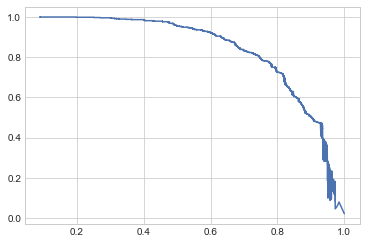

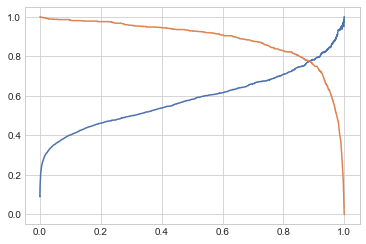

In [26]:
precisions, recalls, thresholds = precision_recall_curve(df_ERA_features.loc[test_mask, "Foehn"], predictions[:,1])
best_threshold = thresholds[np.argmin(abs(precisions-recalls))]

plt.figure()
sns.lineplot(precisions, recalls)
plt.figure()
sns.lineplot(np.append(thresholds, 1.0), precisions)
sns.lineplot(np.append(thresholds, 1.0), recalls)

In [27]:
#best_threshold=0.83
print(f"Best threshold: {best_threshold}")
print(f'Precision: {precision_score(df_ERA_features.loc[test_mask, "Foehn"], (predictions[:,1]>best_threshold).astype(int))}')
print(f'Recall: {recall_score(df_ERA_features.loc[test_mask, "Foehn"], (predictions[:,1]>best_threshold).astype(int))}')
print(confusion_matrix(df_ERA_features.loc[test_mask, "Foehn"], (predictions[:,1]>best_threshold).astype(int)))

Best threshold: 0.8847801089286804
Precision: 0.7750325097529259
Recall: 0.7740259740259741
[[13593   173]
 [  174   596]]


In [28]:
df_ERA_feature_importances = pd.DataFrame({"feature_name": feature_names, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index()
df_ERA_feature_importances.head(50)

,index,feature_name,importance
0,4665,diff_Z_4570_1375_850_Z_4664_375_850,0.294540
1,1911,diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,0.081285
2,2075,diff_SLP_4664_1375_sealevel_SLP_4853_1000_seal...,0.032422
3,9478,diff_PHIT_4382_750_850_PHIT_4853_1000_850,0.025759
4,3394,diff_Z_4287_375_850_Z_4382_1500_850,0.023111
5,1710,diff_SLP_4476_1375_sealevel_SLP_4853_750_sealevel,0.022849
6,7015,diff_Z_4476_1375_700_Z_4570_250_700,0.015370
7,3465,diff_Z_4287_500_850_Z_4476_1375_850,0.015287
8,5104,diff_Z_4853_1000_850_Z_4853_1500_850,0.012933
9,9856,diff_PHIT_4570_1375_850_PHIT_4853_1000_850,0.012753


# Reduce dataframe to most important features

In [29]:
df_ERA_reduced_features = df_ERA_features.loc[:,df_ERA_feature_importances.loc[:50, "feature_name"]]
feature_names_reduced = df_ERA_reduced_features.columns.tolist()
df_ERA_reduced_features["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features["Foehn"] = df_ERA_all_features["Foehn"]

# Transform features to quantiles on ERA

In [30]:
quantile_scaler_ERA = QuantileTransformer(subsample=10**(6), random_state=42)
df_ERA_reduced_train = df_ERA_reduced_features.loc[train_mask, feature_names_reduced]
df_ERA_reduced_test = df_ERA_reduced_features.loc[test_mask, feature_names_reduced]
quantile_scaler_ERA.fit(df_ERA_reduced_train)
df_ERA_reduced_features_scaled_train = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_train), columns = feature_names_reduced, index=df_ERA_reduced_train.index)
df_ERA_reduced_features_scaled_test = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_test), columns = feature_names_reduced, index=df_ERA_reduced_test.index)

df_ERA_reduced_features_scaled = pd.concat([df_ERA_reduced_features_scaled_train, df_ERA_reduced_features_scaled_test], axis=0).sort_index()
df_ERA_reduced_features_scaled["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features_scaled["Foehn"] = df_ERA_all_features["Foehn"]



# Fit XGBoost to reduced feature set & evaluate

In [31]:
# model = xgb.XGBClassifier(
#                     max_depth=3,
#                     learning_rate=0.2,
#                     gamma=0.0,
#                     min_child_weight=0.0,
#                     max_delta_step=0.0,
#                     subsample=1.0,
#                     colsample_bytree=1.0,
#                     colsample_bylevel=1.0,
#                     reg_alpha=10.0,
#                     reg_lambda=1.0,
#                     n_estimators=100,
#                     verbosity=2,
#                     nthread=30,
#                     scale_pos_weight=1.0,
#                     base_score=0.2,
#                     seed=1337,
#                     missing=None,
#                   )
model.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced], df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"], sample_weight=df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"]*20+1)

[21:32:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:32:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:32:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:32:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:32:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:32:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:32:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:32:47] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[21:32:47] INFO: /workspace/src/tree/upd

XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0.0, max_depth=3,
              min_child_weight=0.0, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=40, nthread=40, num_parallel_tree=1,
              random_state=1337, reg_alpha=10.0, reg_lambda=1.0,
              scale_pos_weight=1.0, seed=1337, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=2)

In [37]:
predictions = model.predict_proba(df_ERA_reduced_features_scaled.loc[test_mask, feature_names_reduced])

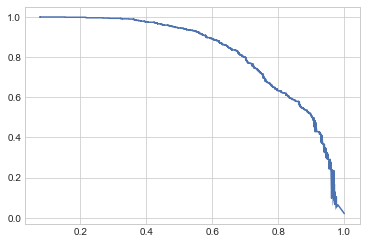

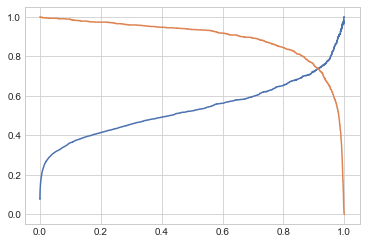

In [38]:
precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], predictions[:,1])
best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]

plt.figure()
sns.lineplot(precisions, recalls)
plt.figure()
sns.lineplot(np.append(thresholds, 1.0), precisions)
sns.lineplot(np.append(thresholds, 1.0), recalls)

In [39]:
#best_threshold_ERA=0.8
print(f"Best threshold: {best_threshold_ERA}")
print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], (predictions[:,1]>best_threshold_ERA).astype(int))}')
print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], (predictions[:,1]>best_threshold_ERA).astype(int))}')
print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], (predictions[:,1]>best_threshold_ERA).astype(int)))

Best threshold: 0.9134150147438049
Precision: 0.7373211963589077
Recall: 0.7363636363636363
[[13564   202]
 [  203   567]]


In [40]:
df_ERA_feature_importances_reduced = pd.DataFrame({"feature_name": feature_names_reduced, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index()
df_ERA_feature_importances_reduced

,index,feature_name,importance
0,0,diff_Z_4570_1375_850_Z_4664_375_850,0.421364
1,1,diff_SLP_4570_1375_sealevel_SLP_4853_875_sealevel,0.194395
2,3,diff_PHIT_4382_750_850_PHIT_4853_1000_850,0.060177
3,13,diff_Z_4287_500_850_Z_4382_1125_850,0.019227
4,4,diff_Z_4287_375_850_Z_4382_1500_850,0.018292
5,30,diff_Z_4287_375_850_Z_4382_875_850,0.017489
6,11,diff_Z_4570_1375_850_Z_4570_375_850,0.017191
7,5,diff_SLP_4476_1375_sealevel_SLP_4853_750_sealevel,0.014818
8,6,diff_Z_4476_1375_700_Z_4570_250_700,0.012561
9,22,diff_Z_4853_875_850_Z_4947_1500_850,0.011833


In [41]:
df_ERA_reduced_features_scaled["prediction_proba"] = model.predict_proba(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
df_ERA_reduced_features_scaled["prediction"] = (df_ERA_reduced_features_scaled["prediction_proba"]> best_threshold_ERA).astype(int)
df_ERA_reduced_features_scaled["dataset"] = "ERA"
df_ERA_reduced_features_scaled["ensemble"] = "ERA"

# Plot monthly accuracies for ERA

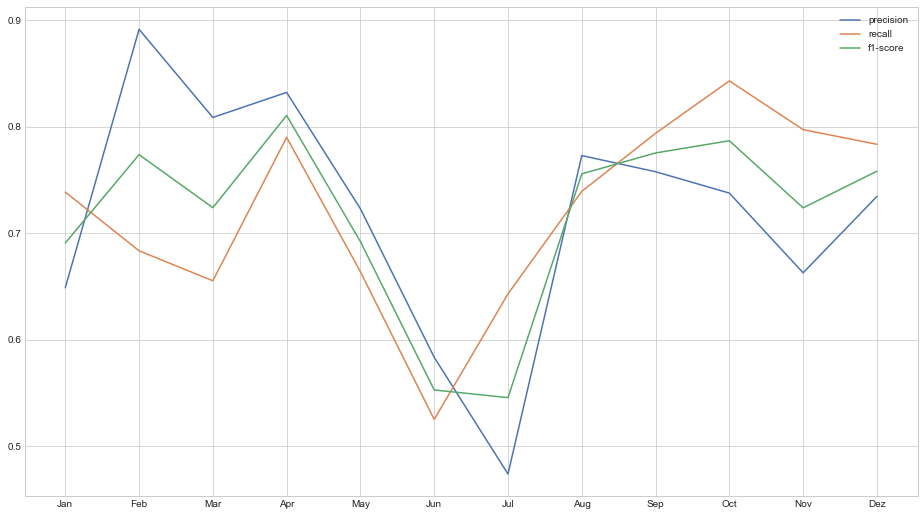

In [42]:
precision_scores = []
recall_scores = []
f1_scores =[]
for month in range(1,12+1):
    df_monthly_predicted_values = df_ERA_reduced_features_scaled.loc[(df_ERA_reduced_features_scaled["date"].dt.month==month) & test_mask, :]
    precision_scores.append(precision_score(df_monthly_predicted_values["Foehn"], df_monthly_predicted_values["prediction"]))
    recall_scores.append(recall_score(df_monthly_predicted_values["Foehn"], df_monthly_predicted_values["prediction"]))
    f1_scores.append(f1_score(df_monthly_predicted_values["Foehn"], df_monthly_predicted_values["prediction"]))

plt.figure(figsize=(16,9))
plt.plot(MONTH_NAMES, precision_scores)
plt.plot(MONTH_NAMES, recall_scores)
plt.plot(MONTH_NAMES, f1_scores)
plt.legend(["precision", "recall", "f1-score"])

# Load CESM data 

In [31]:
df_CESMp = pd.read_csv("/net/litho/atmosdyn2/chmony/data/FoehnAndMeteorologicalData/CESM_present_day.csv.gz")
df_CESMp["date"] = pd.to_datetime(df_CESMp["date"], format="%Y-%m-%dT%H:%M:00.000000Z")

In [32]:
df_CESMf = pd.read_csv("/net/litho/atmosdyn2/chmony/data/FoehnAndMeteorologicalData/CESM_future_day.csv.gz")
df_CESMf["date"] = pd.to_datetime(df_CESMf["date"], format="%Y-%m-%dT%H:%M:00.000000Z")

In [33]:
# Create pot. temp features for CESMp
df_T= df_CESMp.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMp.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMp.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMp = pd.concat([df_CESMp, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

# Create pot. temp features for CESMf
df_T= df_CESMf.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMf.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMf.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMf = pd.concat([df_CESMf, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

del df_PHIT_900, df_PHIT_850, df_PHIT_700

In [34]:
feature_dict_CESMp = {}
feature_dict_CESMf = {}
for feature_name in feature_names_reduced:
    if feature_name[0:6] == "diff_S":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_Z":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_P":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "DELTAP":
        feature_name_splitted = feature_name.split("_")
        first_feature = "PHIT_" + "_".join(feature_name_splitted[1:4])
        second_feature = "PHIT_" + "_".join(feature_name_splitted[1:3]) + "_900"
        
        feature_dict_CESMp["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values
    
    else:
        feature_dict_CESMp[feature_name] = df_CESMp.loc[:, feature_name].values
        feature_dict_CESMf[feature_name] = df_CESMf.loc[:, feature_name].values

feature_dict_CESMp["date"] =df_CESMp.loc[:, "date"].values
feature_dict_CESMf["date"] =df_CESMf.loc[:, "date"].values

feature_dict_CESMp["ensemble"] =df_CESMp.loc[:, "ensemble"].values
feature_dict_CESMf["ensemble"] =df_CESMf.loc[:, "ensemble"].values

df_CESMp_reduced_features = pd.DataFrame(feature_dict_CESMp)
df_CESMf_reduced_features = pd.DataFrame(feature_dict_CESMf)

# Transform features to quantiles on CESM

In [35]:
quantile_scaler_CESM = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_CESM.fit(df_CESMp_reduced_features.loc[:, feature_names_reduced])

df_CESMp_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMp_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMp_reduced_features.loc[:, feature_names_reduced].index)

df_CESMf_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMf_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMf_reduced_features.loc[:, feature_names_reduced].index)

df_CESMp_reduced_features_scaled["date"] = df_CESMp_reduced_features["date"]
df_CESMf_reduced_features_scaled["date"] = df_CESMf_reduced_features["date"]

df_CESMp_reduced_features_scaled["ensemble"] = df_CESMp_reduced_features["ensemble"]
df_CESMf_reduced_features_scaled["ensemble"] = df_CESMf_reduced_features["ensemble"]

# Predict on CESMp and CESMf

In [36]:
df_CESMp_reduced_features_scaled["prediction_proba"] = model.predict_proba(df_CESMp_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
df_CESMp_reduced_features_scaled["prediction"] = (df_CESMp_reduced_features_scaled["prediction_proba"]> best_threshold_ERA).astype(int)
df_CESMp_reduced_features_scaled["dataset"] = "CESMp"
df_CESMf_reduced_features_scaled["prediction_proba"] = model.predict_proba(df_CESMf_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
df_CESMf_reduced_features_scaled["prediction"] = (df_CESMf_reduced_features_scaled["prediction_proba"]> best_threshold_ERA).astype(int)
df_CESMf_reduced_features_scaled["dataset"] = "CESMf"

# Concenate all dataframes

In [48]:
df_foehn = df_ERA_reduced_features_scaled.loc[:, ["date", "Foehn"]]
df_foehn["dataset"] = "observed_foehn"
df_foehn["ensemble"] = "observed_foehn"
df_foehn["prediction"] =df_ERA_reduced_features_scaled.loc[:, "Foehn"]
df_foehn.drop(["Foehn"], axis=1, inplace=True)

In [49]:
df_foehn_ERA_CESMp_CESMf = pd.concat([df_foehn, df_ERA_reduced_features_scaled, df_CESMp_reduced_features_scaled, df_CESMf_reduced_features_scaled], axis=0, ignore_index=True)

In [50]:
df_foehn_ERA_CESMp_CESMf["month"] = df_foehn_ERA_CESMp_CESMf["date"].dt.month
df_foehn_ERA_CESMp_CESMf["year"] = df_foehn_ERA_CESMp_CESMf["date"].dt.year

In [51]:
df_monthly_mean = df_foehn_ERA_CESMp_CESMf[["date", "year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble", "year", "month"], axis=0, as_index=False).mean()

In [52]:
test_mask_final_plot = ((1990< df_monthly_mean["year"]) & (df_monthly_mean["year"]<2001)) | (2090< df_monthly_mean["year"])
df_monthly_mean_testset = df_monthly_mean[test_mask_final_plot]

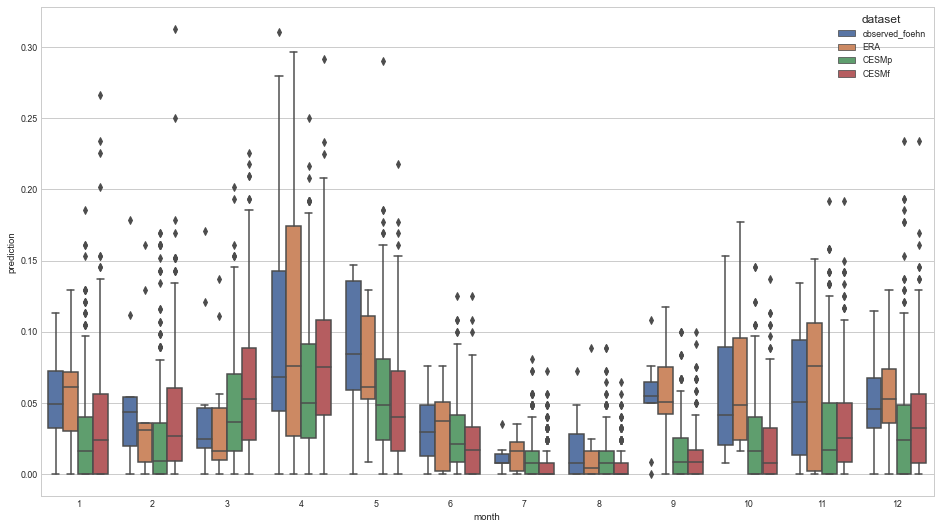

In [108]:
plt.figure(figsize=(16,9))
sns.boxplot(x="month", y="prediction", data=df_monthly_mean_testset, hue="dataset", hue_order=["observed_foehn", "ERA", "CESMp", "CESMf"])

# Second statistical test

(0.0, 0.13)

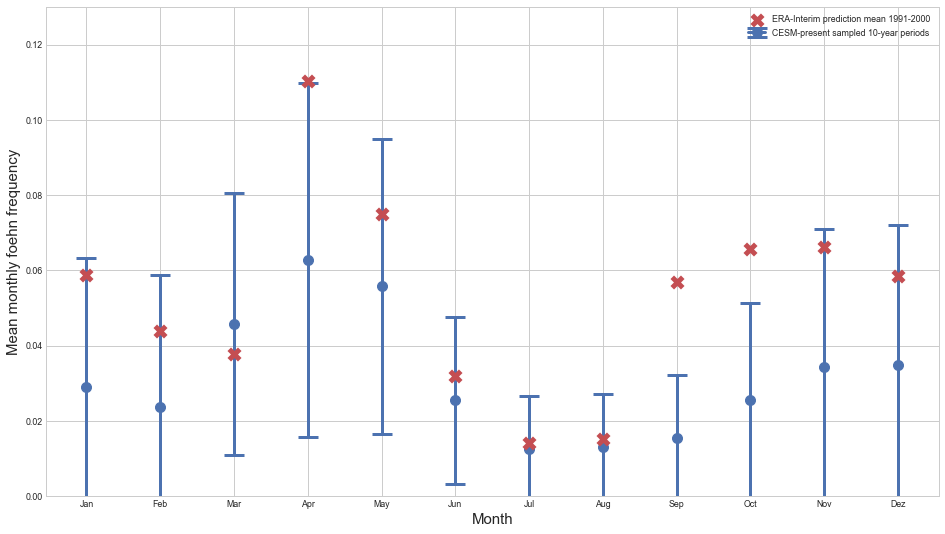

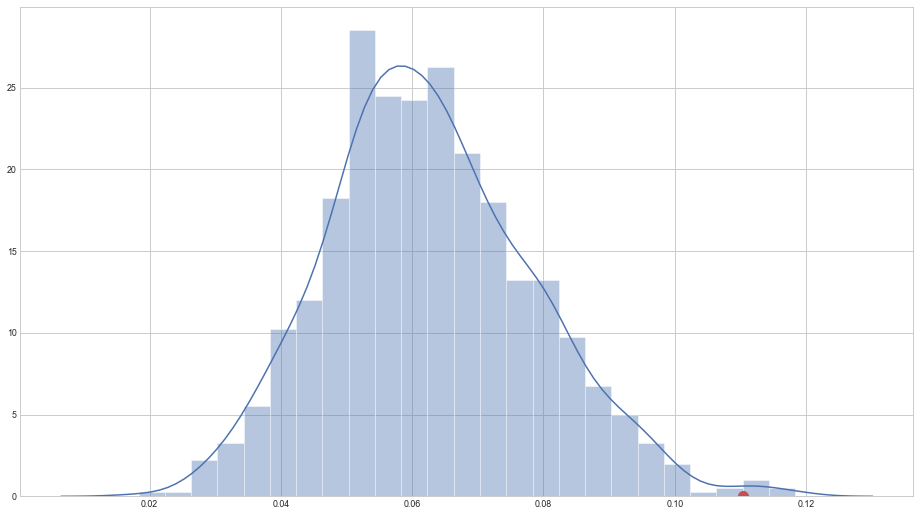

In [107]:
plt.figure(figsize=(16,9))
ax = plt.axes()

for month_test in range(1, 12+1):
    plt.figure(1)
    CESM_test_distribution = []
    df_CESMp = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    for i in range(1000):
        CESM_test_distribution_year = []
        for year in range(1991, 2001):
            CESM_test_distribution_year.append(df_CESMp.loc[df_CESMp["year"]==year, "prediction"].sample(1))
        CESM_test_distribution.append(np.mean(CESM_test_distribution_year))
#     if month_test == 2:
#         plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
#                      yerr = np.array([[2.34*np.array(CESM_test_distribution).std(),3*np.array(CESM_test_distribution).std()]]).T, 
#                      color="b", 
#                      marker="o",
#                      markersize=10, 
#                      linewidth=3, 
#                      capsize=10, 
#                      capthick=3, 
#                      zorder=1)
#         plt.scatter(month_test, (df_sum.loc[(df_sum["original_dataset"]=="ERA") & (df_sum["month"]==month_test), "prediction"]).mean(), 
#                     marker="x", 
#                     color="r", 
#                     s=110, 
#                     linewidth=5, 
#                     zorder=10)
#     else:
    plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
                 yerr = 3*np.array(CESM_test_distribution).std(), 
                 color="b", 
                 marker="o",
                 markersize=10, 
                 linewidth=3, 
                 capsize=10, 
                 capthick=3, 
                 zorder=1)
    plt.scatter(month_test, (df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"]).mean(), 
                marker="x", 
                color="r", 
                s=110, 
                linewidth=5, 
                zorder=10)

    if month_test==4:
        plt.figure(figsize=(16,9))
        sns.distplot(CESM_test_distribution)
        plt.plot(df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"].mean(),0, 
                "ro", 
                markersize=10)
    
    if month_test==1: # To make plot prettier
        legend = ax.legend(["ERA-Interim prediction mean 1991-2000", "CESM-present sampled 10-year periods"])
        
ax.set(xticklabels=MONTH_NAMES, xticks=range(1,12+1))
ax.set_xlabel("Month",fontsize=15)
ax.set_ylabel("Mean monthly foehn frequency",fontsize=15)
ax.set_ylim((0,0.13))


# Third statistical test

In [55]:
for month_test in range(1, 12+1):
    CESMp_test_distribution = []
    CESMf_test_distribution = []
    df_CESMp_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMf") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ks_2samp(df_CESMp_month["prediction"], df_CESMf_month["prediction"])

    print(MONTH_NAMES[month_test-1] +"\t" +str(np.round(p,5)) + "\t" + str(p<0.01))

Jan	0.15287	False
Feb	0.0	True
Mar	5e-05	True
Apr	0.00025	True
May	0.06034	False
Jun	0.00469	True
Jul	1e-05	True
Aug	0.0	True
Sep	0.33414	False
Oct	0.07352	False
Nov	0.07352	False
Dez	0.33414	False


# Ensemble deviation

Text(0, 0.5, 'Mean monthly foehn prediction')

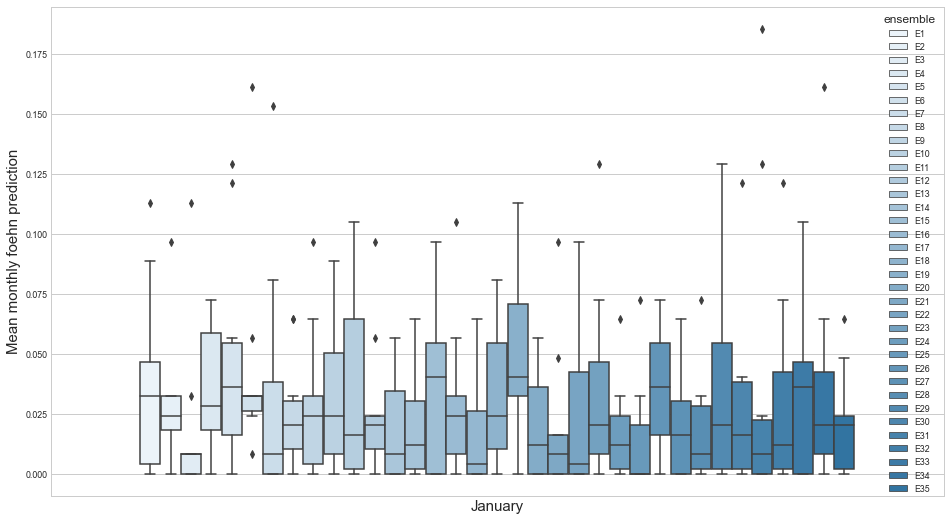

In [103]:
df_ensemble = df_foehn_ERA_CESMp_CESMf.loc[df_foehn_ERA_CESMp_CESMf["dataset"]=="CESMp"].groupby(["ensemble", "year", "month"], as_index=False).mean()

plt.figure(figsize=(16,9))
ax = sns.boxplot(x="month", y="prediction", data=df_ensemble.loc[df_ensemble["month"]==1,:], hue="ensemble", hue_order=["E"+str(i) for i in range(1,35+1)], color="tab:blue")

ax.set(xticks=[])
ax.set_xlabel("January",fontsize=15)
ax.set_ylabel("Mean monthly foehn prediction",fontsize=15)
# sns.set(font_scale=0.8)